In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree
import pickle

from sklearn.model_selection import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor
import statsmodels.formula.api as sm
from sklearn.metrics import *
from sklearn.linear_model import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from run_model import *

import gmaps
gmaps.configure(api_key=secret_key.google_api_key)

In [2]:
def clean_citibike(df):
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    df['Stop Time'] = pd.to_datetime(df['Stop Time'])
    
    df['DATE'] = df['Start Time'].dt.date
    
    df['day'] = df['Start Time'].dt.day
    df['month'] = df['Start Time'].dt.month
    df['year'] = df['Start Time'].dt.year
    
    df['day_of_week_name'] = df['Start Time'].dt.weekday_name
    df['day_of_week'] = df['Start Time'].dt.weekday
    
    df['time_of_day'] = df['Start Time'].dt.hour
    df["bin_time_of_day"] = df["Start Time"].apply(bin_time)
    
    grp = df.groupby(['Start Station Name', 'DATE', 'time_of_day'])
    
    df = grp['Bike ID'].count().reset_index()
    df = df.rename(index=str, columns={'Bike ID': "target"})
    
    df = pd.merge(df, bik_loc, on='Start Station Name', how="left")
    
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    df['day'] = df['DATE'].dt.day
    df['month'] = df['DATE'].dt.month
    df['year'] = df['DATE'].dt.year
    
    df['day_of_week_name'] = df['DATE'].dt.weekday_name
    df['day_of_week'] = df['DATE'].dt.weekday
    
    df['log_target'] = df['target'].apply(lambda x: np.log(x))
    
    return df

In [3]:
bike_df1 = pd.read_csv("data/citibike2/201801-citibike-tripdata.csv.zip")
bike_df2 = pd.read_csv("data/citibike2/201802-citibike-tripdata.csv.zip")
bike_df3 = pd.read_csv("data/citibike2/201803-citibike-tripdata.csv.zip")
bike_df4 = pd.read_csv("data/citibike2/201804-citibike-tripdata.csv.zip")
bike_df5 = pd.read_csv("data/citibike2/201805-citibike-tripdata.csv.zip")
bike_df6 = pd.read_csv("data/citibike2/201806-citibike-tripdata.csv.zip")
bike_df7 = pd.read_csv("data/citibike2/201807-citibike-tripdata.csv.zip")

In [4]:
# bike_df0 = pd.read_csv("data/citibike/201701-citibike-tripdata.csv.zip")
# bike_df1 = pd.read_csv("data/citibike/201702-citibike-tripdata.csv.zip")
# bike_df2 = pd.read_csv("data/citibike/201703-citibike-tripdata.csv.zip")
# bike_df3 = pd.read_csv("data/citibike/201704-citibike-tripdata.csv.zip")
# bike_df3 = bike_df3.rename({'tripduration':'Trip Duration', 'starttime':"Start Time", 'stoptime':"Stop Time", 'start station id': "Start Station ID",
#        'start station name': "Start Station Name", 'start station latitude':" Start Station Latitude",
#        'start station longitude':"Start Station Longitude", 'end station id' : "End Station ID", 'end station name':"End Station Name",
#        'end station latitude':"End Station Latitude", 'end station longitude':"End Station Longitude", 'bikeid':"Bike ID", 'usertype':"User Type",
#        'birth year':"Birt Year", 'gender':"Gender"}, axis=1)

# bike_df4 = pd.read_csv("data/citibike/201705-citibike-tripdata.csv.zip")
# bike_df4 = bike_df4.rename({'tripduration':'Trip Duration', 'starttime':"Start Time", 'stoptime':"Stop Time", 'start station id': "Start Station ID",
#        'start station name': "Start Station Name", 'start station latitude':" Start Station Latitude",
#        'start station longitude':"Start Station Longitude", 'end station id' : "End Station ID", 'end station name':"End Station Name",
#        'end station latitude':"End Station Latitude", 'end station longitude':"End Station Longitude", 'bikeid':"Bike ID", 'usertype':"User Type",
#        'birth year':"Birt Year", 'gender':"Gender"}, axis=1)

# bike_df5 = pd.read_csv("data/citibike/201706-citibike-tripdata.csv.zip")
# bike_df5 = bike_df5.rename({'tripduration':'Trip Duration', 'starttime':"Start Time", 'stoptime':"Stop Time", 'start station id': "Start Station ID",
#        'start station name': "Start Station Name", 'start station latitude':" Start Station Latitude",
#        'start station longitude':"Start Station Longitude", 'end station id' : "End Station ID", 'end station name':"End Station Name",
#        'end station latitude':"End Station Latitude", 'end station longitude':"End Station Longitude", 'bikeid':"Bike ID", 'usertype':"User Type",
#        'birth year':"Birt Year", 'gender':"Gender"}, axis=1)

# # bike_df6 = pd.read_csv("data/citibike/201707-citibike-tripdata.csv.zip")
# # bike_df7 = pd.read_csv("data/citibike/201708-citibike-tripdata.csv.zip")
# # bike_df8 = pd.read_csv("data/citibike/201709-citibike-tripdata.csv.zip")
# # bike_df9 = pd.read_csv("data/citibike/201710-citibike-tripdata.csv.zip")
# # bike_df10 = pd.read_csv("data/citibike/201711-citibike-tripdata.csv.zip")
# # bike_df11 = pd.read_csv("data/citibike/201712-citibike-tripdata.csv.zip")

bike_df = load_pickle("storage/bike_df_final.pckl")

In [5]:
# bike_df = pd.concat([bike_df1, bike_df2, bike_df3, bike_df4, bike_df5, bike_df6])

# del bike_df1
# del bike_df2
# del bike_df3
# del bike_df4
# del bike_df5
# del bike_df6
# del bike_df7

bike_df = bike_df.rename({'tripduration':'Trip Duration', 'starttime':"Start Time", 'stoptime':"Stop Time", 'start station id': "Start Station ID",
       'start station name': "Start Station Name", 'start station latitude':"Start Station Latitude",
       'start station longitude':"Start Station Longitude", 'end station id' : "End Station ID", 'end station name':"End Station Name",
       'end station latitude':"End Station Latitude", 'end station longitude':"End Station Longitude", 'bikeid':"Bike ID", 'usertype':"User Type",
       'birth year':"Birt Year", 'gender':"Gender"}, axis=1)

bik_loc = bike_df.groupby(["Start Station Name", "Start Station Latitude", "Start Station Longitude"])['Bike ID'].count().reset_index()
bik_loc = bik_loc.drop("Bike ID", axis=1)

In [6]:
bike_df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,name_localizedValue0,User Type,Birt Year,Gender
0,196,2018-01-01 00:01:51,2018-01-01 00:05:07,315,South St & Gouverneur Ln,40.703554,-74.006702,259,South St & Whitehall St,40.701221,-74.012342,18534,Annual Membership,Subscriber,1997.0,1
1,207,2018-01-01 00:02:44,2018-01-01 00:06:11,3224,W 13 St & Hudson St,40.739974,-74.005139,470,W 20 St & 8 Ave,40.743453,-74.000040,19651,Annual Membership,Subscriber,1978.0,1
2,613,2018-01-01 00:03:15,2018-01-01 00:13:28,386,Centre St & Worth St,40.714948,-74.002345,2008,Little West St & 1 Pl,40.705693,-74.016777,21678,Annual Membership,Subscriber,1982.0,1
3,375,2018-01-01 00:06:44,2018-01-01 00:12:59,466,W 25 St & 6 Ave,40.743954,-73.991449,325,E 19 St & 3 Ave,40.736245,-73.984738,29822,Annual Membership,Subscriber,1982.0,1
4,402,2018-01-01 00:06:57,2018-01-01 00:13:40,438,St Marks Pl & 1 Ave,40.727791,-73.985649,380,W 4 St & 7 Ave S,40.734011,-74.002939,30722,Annual Membership,Subscriber,1989.0,1


In [6]:
# bike_df = bike_df.sort_values('DATE')
rows = bike_df.shape[0]
train = bike_df.head(int(rows*0.8))
test = bike_df.tail(int(rows*0.2))
# del bike_df

In [7]:
train = clean_citibike(train)
test = clean_citibike(test)

/home/iniyavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/iniyavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/iniyavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [9]:
low = train[(train.target <= 2)].sample(n=200000)
med = train[(train.target <= 5) & (train.target > 2)]
high = train[(train.target > 5)]
train = pd.concat([low, med, high])
del low 
del med
del high

In [73]:
exp.target.describe()

count    889057.000000
mean          6.067957
std           6.335660
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         204.000000
Name: target, dtype: float64

In [3]:
train = load_pickle("storage/train_final.pckl")
test = load_pickle("storage/test_final.pckl")

In [8]:
store_pickle("storage/train_final.pckl", train)
store_pickle("storage/test_final.pckl", test)

In [19]:
train.head()

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target
0,1 Ave & E 110 St,2018-01-01,5,1,40.792327,-73.9383,1,1,2018,Monday,0,0.0
1,1 Ave & E 110 St,2018-01-01,14,1,40.792327,-73.9383,1,1,2018,Monday,0,0.0
2,1 Ave & E 110 St,2018-01-02,5,1,40.792327,-73.9383,2,1,2018,Tuesday,1,0.0
3,1 Ave & E 110 St,2018-01-02,7,1,40.792327,-73.9383,2,1,2018,Tuesday,1,0.0
4,1 Ave & E 110 St,2018-01-02,8,1,40.792327,-73.9383,2,1,2018,Tuesday,1,0.0


In [23]:
eda = train.groupby("DATE")["target"].count().reset_index()

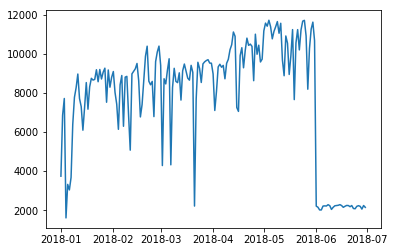

In [24]:
plt.plot(eda['DATE'], eda['target']);

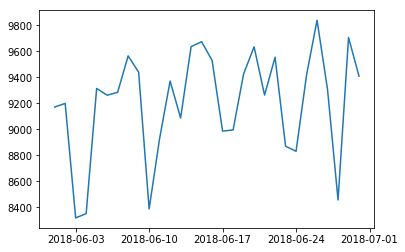

In [25]:
eda = test.groupby("DATE")["target"].count().reset_index()
plt.plot(eda['DATE'], eda['target']);

## Linear Regression

In [6]:
def score_log(y_pred, y_actual):
   log_diff = np.log(y_pred+1) - np.log(y_actual+1)
   return np.sqrt(np.mean(log_diff**2))

In [16]:
features = ['time_of_day', 'day', 'month', 'year', 'day_of_week']

lin_model = LinearRegression()
lin_model.fit(train[features], train['target'])
y_pred = lin_model.predict(test[features])

print(score_log(train['target'].mean(), train['target']))
print(score_log(y_pred, test['target']))

0.7465850327929326
0.8522212442490568


In [18]:
test.corr()['target']

time_of_day                0.092172
target                     1.000000
Start Station Latitude     0.055424
Start Station Longitude   -0.295587
day                       -0.002487
month                           NaN
year                            NaN
day_of_week               -0.055234
log_target                 0.811053
Name: target, dtype: float64

## RandomForest

In [19]:
features = ['time_of_day', 'day', 'month', 'year', 'day_of_week']

In [23]:
def randomforestModel(col, label):
    rfrmodel = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    reg = rfrmodel.fit(train[col], train[label])

    training_accuracy = reg.score(train[col], train[label])
    test_accuracy = reg.score(test[col], test[label])

    log_error = mean_squared_log_error(test[label], rfrmodel.predict(test[col]))

    print("############# based on standard predict ################")
    print("R^2 on training data: %0.4f" % (training_accuracy))
    print("R^2 on test data:     %0.4f" % (test_accuracy))
    print("Log on test data:     %0.4f" % (log_error))

    y_test = test[label]
    y_pred = rfrmodel.predict(test[col])
    
#     test['log_pred'] = y_pred
    
#     test['pred'] = np.exp(y_pred)
    test['pred'] = y_pred
    
    percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
    print("Percent Error:" , np.mean(percent_error))

    avg_error = (abs(y_pred - y_test + 1))
    print("Avg Error:", np.mean(avg_error))

    test['percent_error'] = percent_error
    test['avg_error'] = avg_error
    
    print("RMLSE:", score_log(y_pred, y_test))

In [24]:
randomforestModel(features, 'target')

############# based on standard predict ################
R^2 on training data: 0.1779
R^2 on test data:     0.0648
Log on test data:     0.6803
Percent Error: 1.3253940490768295
Avg Error: 5.058158981994561
RMLSE: 0.8248087498419974


## CatBoost

In [4]:
features = ['Start Station Name', 'time_of_day', 'day', 'month', 'day_of_week_name']
cat = [0]

cat_train = train[features]
cat_test = test[features]
train_pool = Pool(cat_train, train['target'], cat_features=[0, 4])
test_pool = Pool(cat_test, cat_features=[0, 4])
catmodel = CatBoostRegressor(iterations=150, depth=15)
catmodel.fit(train_pool)

0:	learn: 6.8689282	total: 4.69s	remaining: 11m 38s
1:	learn: 6.7272122	total: 9.1s	remaining: 11m 13s
2:	learn: 6.5910603	total: 12.6s	remaining: 10m 18s
3:	learn: 6.4610891	total: 16.4s	remaining: 9m 58s
4:	learn: 6.3355363	total: 19.8s	remaining: 9m 33s
5:	learn: 6.2146964	total: 23.2s	remaining: 9m 16s
6:	learn: 6.0976905	total: 27.6s	remaining: 9m 23s
7:	learn: 5.9864140	total: 31.1s	remaining: 9m 11s
8:	learn: 5.8782551	total: 35.5s	remaining: 9m 15s
9:	learn: 5.7748831	total: 39.2s	remaining: 9m 8s
10:	learn: 5.6750559	total: 42.9s	remaining: 9m 1s
11:	learn: 5.5800482	total: 46.6s	remaining: 8m 56s
12:	learn: 5.4887545	total: 50.5s	remaining: 8m 52s
13:	learn: 5.4012993	total: 54.3s	remaining: 8m 47s
14:	learn: 5.3165947	total: 58s	remaining: 8m 41s
15:	learn: 5.2356246	total: 1m 1s	remaining: 8m 36s
16:	learn: 5.1580650	total: 1m 5s	remaining: 8m 32s
17:	learn: 5.0830627	total: 1m 9s	remaining: 8m 27s
18:	learn: 5.0113668	total: 1m 12s	remaining: 8m 22s
19:	learn: 4.9430672	to

In [7]:
y_pred = catmodel.predict(test_pool)
y_test = np.exp(test['log_target'])
test['pred']= y_pred
# test['log_pred'] = y_pred

# test['pred'] = np.exp(y_pred)
# y_pred = test['pred']a



log_error = mean_squared_log_error(y_test, y_pred)

print("############# based on standard predict ################")

print("Log on test data:     %0.4f" % (log_error))

percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print("Percent Error:" , np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print("Avg Error:", np.mean(avg_error))

test['percent_error'] = percent_error
test['avg_error'] = avg_error
# catmodel.score(test['target'], test['pred'])



y_avg = y_test.mean()

print(score_log(y_pred, y_test))
# print(score_log(y_avg, y_test))

############# based on standard predict ################
Log on test data:     0.2352
Percent Error: 0.4972994328540091
Avg Error: 2.7095298367821283
0.48494329060924346


In [8]:
test[['pred', 'target']]

,pred,target
0,1.098454,1
1,1.098454,1
2,1.113903,1
3,2.714536,3
4,3.875519,2
5,3.169244,3
6,2.018942,1
7,2.015276,1
8,2.079704,3
9,2.110964,1


In [11]:
y_pred = train.target.mean()
y_actual = train['target']
score_log(y_pred, y_actual)

0.7465850327929326

In [12]:
grp = train.groupby(['Start Station Name', 'DATE', 'time_of_day'])
met = grp['target'].mean().reset_index()
app = pd.merge(met, train, on=['Start Station Name', 'DATE', 'time_of_day'])
y_pred = app.target_x
y_actual = train.target
score_log(y_pred, y_actual)

0.0

In [14]:
test = test.dropna()
locations = test[['Start Station Latitude', 'Start Station Longitude']]
#Get the magnitude from the data
weights = test['target']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

In [47]:
test = test.dropna()
locations = test[['Start Station Latitude', 'Start Station Longitude']]
#Get the magnitude from the data
weights = test['pred']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

In [35]:
test.head()

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target,pred,percent_error,avg_error
0,1 Ave & E 110 St,2018-06-01,3,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.114196,0.557098,1.114196
1,1 Ave & E 110 St,2018-06-01,4,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.114196,0.557098,1.114196
2,1 Ave & E 110 St,2018-06-01,5,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.124563,0.562282,1.124563
3,1 Ave & E 110 St,2018-06-01,7,3,40.792327,-73.9383,1,6,2018,Friday,4,1.098612,2.676713,0.169178,0.676713
4,1 Ave & E 110 St,2018-06-01,8,2,40.792327,-73.9383,1,6,2018,Friday,4,0.693147,3.760116,0.920039,2.760116


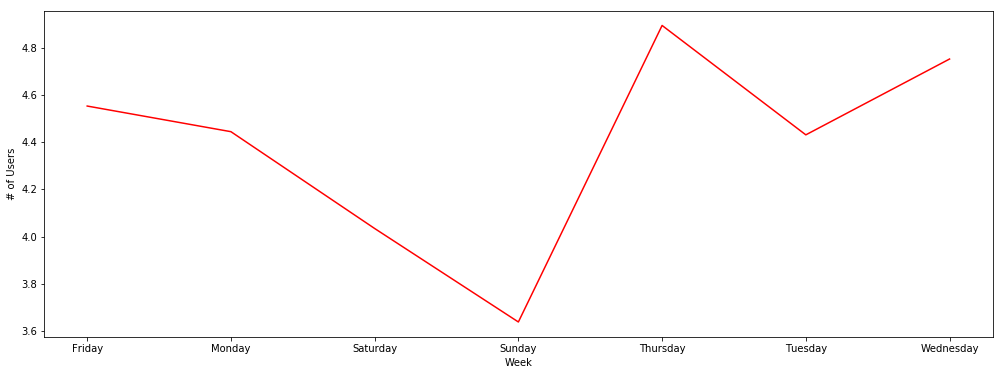

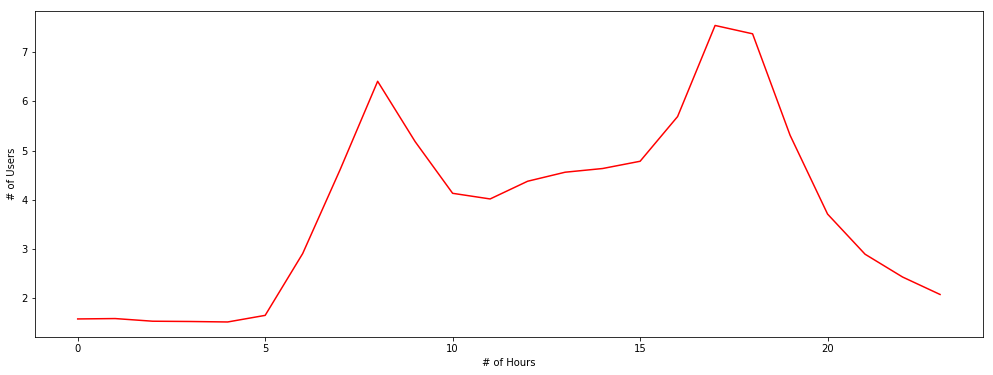

In [40]:
def graph_user_per_month(station_name):
#     fig, ax = plt.subplots(1, 2)
    
    fig = plt.figure(figsize=(17,6))
    station_avg_day = test[test['Start Station Name'] == station_name].groupby(['day_of_week_name'])[['target', 'pred']].mean().reset_index()
#     plt.plot(station_avg_day['day'], station_avg_day['target'], color='blue')
    plt.plot(station_avg_day['day_of_week_name'], station_avg_day['pred'], color='red')
    plt.xlabel("Week")
    plt.ylabel("# of Users");
    plt.show()
    fig = plt.figure(figsize=(17,6))
    station_avg_time = test[test['Start Station Name'] == station_name].groupby(['time_of_day'])[['target', 'pred']].mean().reset_index()
#     plt.plot(station_avg_time['time_of_day'], station_avg_time['target'], color='blue')
    plt.plot(station_avg_time['time_of_day'], station_avg_time['pred'], color='red')
    plt.xlabel("# of Hours")
    plt.ylabel("# of Users");
    
graph_user_per_month('W 74 St & Columbus Ave')

In [8]:
test.head()

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target,pred,percent_error,avg_error
0,1 Ave & E 110 St,2018-06-01,3,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.281098,0.640549,1.281098
1,1 Ave & E 110 St,2018-06-01,4,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.281098,0.640549,1.281098
2,1 Ave & E 110 St,2018-06-01,5,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.390757,0.695378,1.390757
3,1 Ave & E 110 St,2018-06-01,7,3,40.792327,-73.9383,1,6,2018,Friday,4,1.098612,2.153596,0.038399,0.153596
4,1 Ave & E 110 St,2018-06-01,8,2,40.792327,-73.9383,1,6,2018,Friday,4,0.693147,2.632291,0.544097,1.632291


In [ ]:
import seaborn as sns


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, axisbg='white')
sns.swarmplot(x='Respond to Available', y='Unit Type', data=graphs)

# Show plot
plt.show()

In [52]:
def metrics_citibike(y_test, y_pred):
    percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
    print("Percent Error:" , np.mean(percent_error))

    avg_error = (abs(y_pred - y_test + 1))
    print("Avg Error:", np.mean(avg_error))

In [38]:
store_pickle("storage/test.pckl", test)

In [17]:
test['Start Station Name'].unique()

array(['1 Ave & E 110 St', '1 Ave & E 16 St', '1 Ave & E 18 St',
       '1 Ave & E 30 St', '1 Ave & E 44 St', '1 Ave & E 62 St',
       '1 Ave & E 68 St', '1 Ave & E 78 St', '1 Ave & E 94 St',
       '1 Pl & Clinton St', '10 Hudson Yards', '10 St & 5 Ave',
       '10 St & 7 Ave', '11 Ave & W 27 St', '11 Ave & W 41 St',
       '11 Ave & W 59 St', '11 St & 35 Ave', '11 St & 43 Ave',
       '12 Ave & W 40 St', '12 St & 4 Ave', '14 St & 5 Ave',
       '14 St & 7 Ave', '19 St & 24 Ave',
       '2 Ave & 36 St - Citi Bike HQ at Industry City', '2 Ave & 9 St',
       '2 Ave & E 104 St', '2 Ave & E 122 St', '2 Ave & E 31 St',
       '2 Ave & E 55 St', '2 Ave & E 96 St', '2 Ave & E 99 St',
       '21 St & 31 Dr', '21 St & 36 Ave', '21 St & 38 Ave',
       '21 St & 43 Ave', '21 St & Hoyt Ave S',
       '21 St & Queens Plaza North', '23 Ave & 27 St', '24 Ave & 26 St',
       '24 Ave & 29 St', '24 St & 41 Ave', '27 Ave & 4 St',
       '27 Ave & 9 St', '27 St & Hunter St', '28 Ave & 35 St',
       '

In [20]:
row_list = []

for station in test['Start Station Name'].unique():
    station_avg_users = test[test['Start Station Name'] == station].groupby(['day'])[['target', 'pred']].mean().reset_index()
#     print(station_avg_users)
    
    row_list.append({'Station_name' : station, 'actual' : station_avg_users.mean()[1], 'pred' : station_avg_users.mean()[2]})
#     break

temp = pd.DataFrame(row_list)

In [21]:
temp = temp.sort_values(by=['actual'])

Text(0,0.5,'Number of Users ')

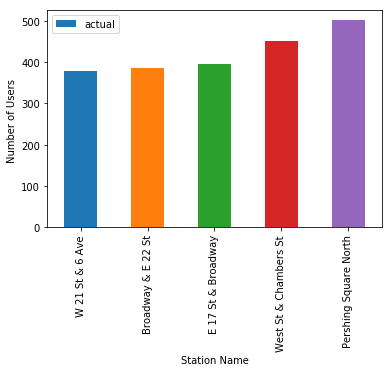

In [11]:
temp.tail(5).plot.bar(x='Station_name', y='actual')
plt.xlabel("Station Name")
plt.ylabel("Number of Users ")

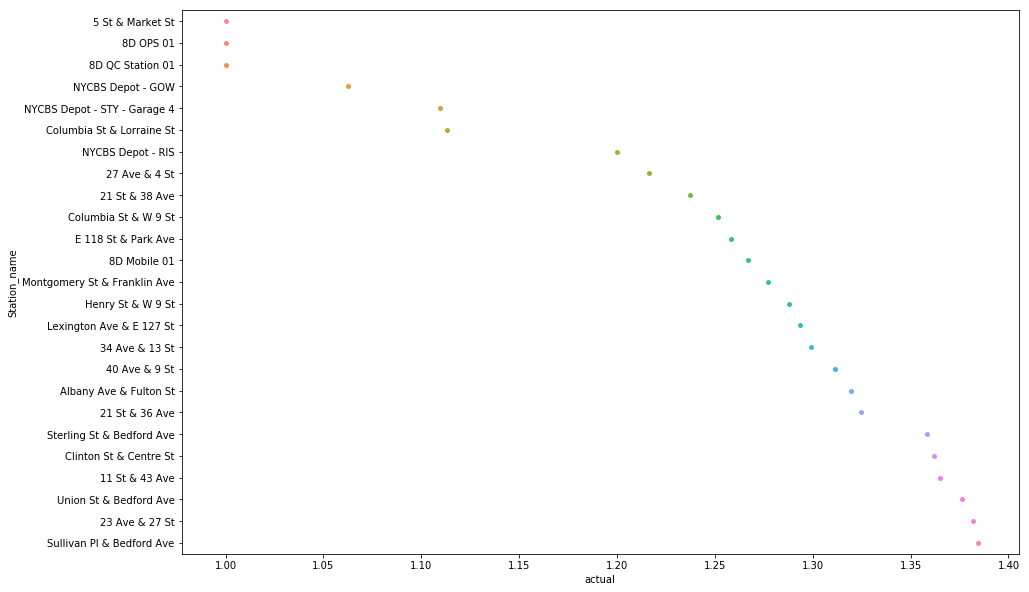

In [60]:
import seaborn as sns
# Construct iris plot
#sns.swarmplot(x='Respond to Available', y='Unit Type', data=df_full)
fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111)
sns.swarmplot(x='actual', y='Station_name', data=temp.head(25))

# Show plot
plt.show()

In [38]:
graph.head()

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target,pred,percent_error,avg_error
62321,Broadway & E 22 St,2018-06-01,0,2,40.740343,-73.989551,1,6,2018,Friday,4,0.693147,1.698038,0.232679,0.698038
62322,Broadway & E 22 St,2018-06-01,1,1,40.740343,-73.989551,1,6,2018,Friday,4,0.000000,1.633959,0.816980,1.633959
62323,Broadway & E 22 St,2018-06-01,2,1,40.740343,-73.989551,1,6,2018,Friday,4,0.000000,1.633959,0.816980,1.633959
62324,Broadway & E 22 St,2018-06-01,6,2,40.740343,-73.989551,1,6,2018,Friday,4,0.693147,3.195309,0.731770,2.195309
62325,Broadway & E 22 St,2018-06-01,7,6,40.740343,-73.989551,1,6,2018,Friday,4,1.791759,5.404333,0.057762,0.404333


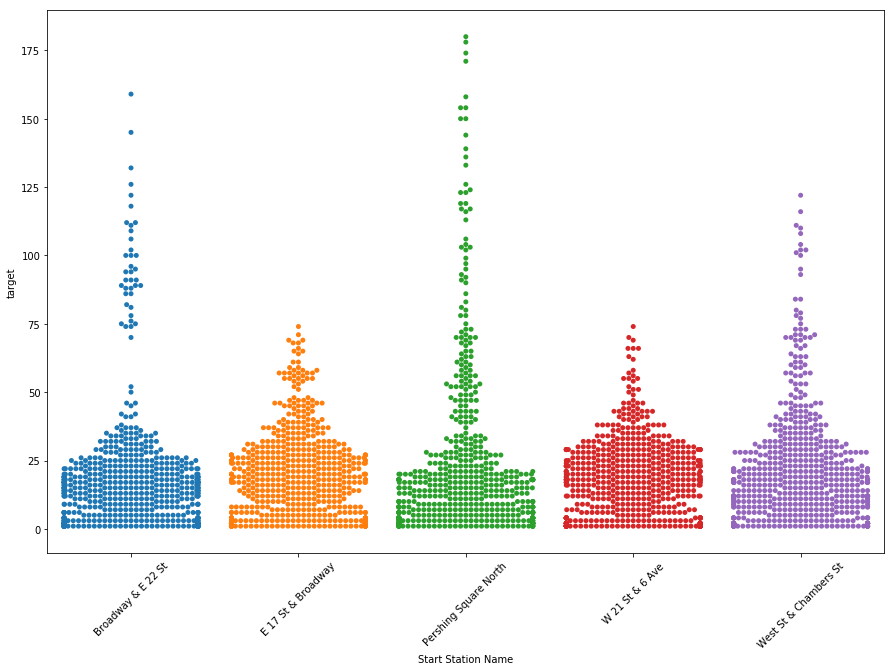

In [46]:
graph = test[((test['Start Station Name'] == 'Pershing Square North') | (test['Start Station Name'] == 'West St & Chambers St') | (test['Start Station Name'] == 'Broadway & E 22 St') | (test['Start Station Name'] == 'E 17 St & Broadway') | (test['Start Station Name'] == 'W 21 St & 6 Ave'))]
# graph.sort_values()
fig = plt.figure(figsize=(15,10))
g = sns.swarmplot(y='target', x='Start Station Name', data=graph)
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45);

In [49]:
low = test[test.target < 20]
med = test[((test.target > 20) & (test.target < 50))]
high = test[test.target > 50]

In [53]:
metrics_citibike(low.target, low.pred)

Percent Error: 0.4974055586444207
Avg Error: 2.0913654421557917


In [54]:
metrics_citibike(med.target, med.pred)

Percent Error: 0.48922494304280617
Avg Error: 14.514378354038183


In [55]:
metrics_citibike(high.target, high.pred)

Percent Error: 0.7314597647856627
Avg Error: 57.425409337011864


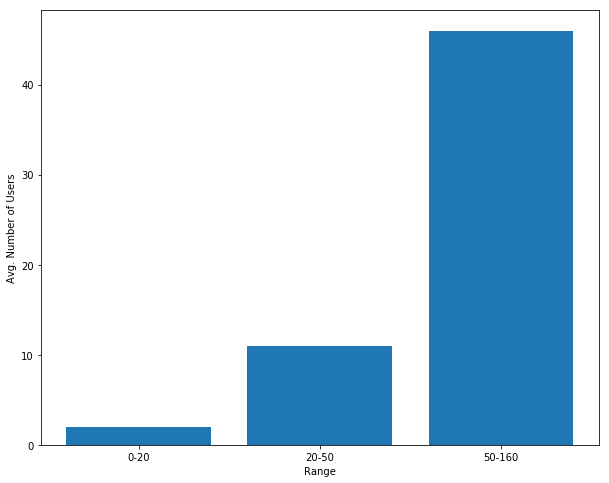

In [23]:
fig = plt.figure(figsize=(10,8))
plt.bar(['0-20', "20-50", '50-160'], [2,11,46]);
plt.xlabel("Range")
plt.ylabel("Avg. Number of Users");

In [132]:
low = test[test.target < 5.0]

Start Station Name         131144
DATE                       131144
time_of_day                131144
target                     131144
Start Station Latitude     131144
Start Station Longitude    131144
day                        131144
month                      131144
year                       131144
day_of_week_name           131144
day_of_week                131144
log_target                 131144
pred                       131144
percent_error              131144
avg_error                  131144
dtype: int64

In [153]:
high.target.max()

160

In [152]:
high.target.mode()

0    61
dtype: int64

In [165]:
high.shape

(319, 15)

In [26]:
high

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target,pred,percent_error,avg_error
8622,12 Ave & W 40 St,2018-06-02,14,53,40.760875,-74.002777,2,6,2018,Saturday,5,3.970292,10.965764,0.759893,41.034236
8625,12 Ave & W 40 St,2018-06-02,17,65,40.760875,-74.002777,2,6,2018,Saturday,5,4.174387,10.908230,0.804421,53.091770
8691,12 Ave & W 40 St,2018-06-06,8,67,40.760875,-74.002777,6,6,2018,Wednesday,2,4.204693,13.358406,0.774141,52.641594
8710,12 Ave & W 40 St,2018-06-07,8,83,40.760875,-74.002777,7,6,2018,Thursday,3,4.418841,13.367874,0.817049,68.632126
8752,12 Ave & W 40 St,2018-06-09,11,52,40.760875,-74.002777,9,6,2018,Saturday,5,3.951244,8.830383,0.795653,42.169617
8757,12 Ave & W 40 St,2018-06-09,16,55,40.760875,-74.002777,9,6,2018,Saturday,5,4.007333,10.917533,0.769330,43.082467
8758,12 Ave & W 40 St,2018-06-09,17,64,40.760875,-74.002777,9,6,2018,Saturday,5,4.158883,10.128066,0.813414,52.871934
8817,12 Ave & W 40 St,2018-06-12,17,51,40.760875,-74.002777,12,6,2018,Tuesday,1,3.931826,15.203833,0.669157,34.796167
8851,12 Ave & W 40 St,2018-06-14,8,80,40.760875,-74.002777,14,6,2018,Thursday,3,4.382027,12.439690,0.821732,66.560310
8871,12 Ave & W 40 St,2018-06-15,8,61,40.760875,-74.002777,15,6,2018,Friday,4,4.110874,12.541305,0.765463,47.458695


In [56]:
locations = low[['Start Station Latitude', 'Start Station Longitude']]
#Get the magnitude from the data
weights = low['pred']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

In [37]:
for i in test['Start Station Name'].unique():
    print("<option label=\""+ i + "\">" + i +")</option>")

<option label="1 Ave & E 110 St">1 Ave & E 110 St)</option>
<option label="1 Ave & E 16 St">1 Ave & E 16 St)</option>
<option label="1 Ave & E 18 St">1 Ave & E 18 St)</option>
<option label="1 Ave & E 30 St">1 Ave & E 30 St)</option>
<option label="1 Ave & E 44 St">1 Ave & E 44 St)</option>
<option label="1 Ave & E 62 St">1 Ave & E 62 St)</option>
<option label="1 Ave & E 68 St">1 Ave & E 68 St)</option>
<option label="1 Ave & E 78 St">1 Ave & E 78 St)</option>
<option label="1 Ave & E 94 St">1 Ave & E 94 St)</option>
<option label="1 Pl & Clinton St">1 Pl & Clinton St)</option>
<option label="10 Hudson Yards">10 Hudson Yards)</option>
<option label="10 St & 5 Ave">10 St & 5 Ave)</option>
<option label="10 St & 7 Ave">10 St & 7 Ave)</option>
<option label="11 Ave & W 27 St">11 Ave & W 27 St)</option>
<option label="11 Ave & W 41 St">11 Ave & W 41 St)</option>
<option label="11 Ave & W 59 St">11 Ave & W 59 St)</option>
<option label="11 St & 35 Ave">11 St & 35 Ave)</option>
<option labe

In [58]:
test.head()

,Start Station Name,DATE,time_of_day,target,Start Station Latitude,Start Station Longitude,day,month,year,day_of_week_name,day_of_week,log_target,pred,percent_error,avg_error
0,1 Ave & E 110 St,2018-06-01,3,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.281098,0.640549,1.281098
1,1 Ave & E 110 St,2018-06-01,4,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.281098,0.640549,1.281098
2,1 Ave & E 110 St,2018-06-01,5,1,40.792327,-73.9383,1,6,2018,Friday,4,0.000000,1.390757,0.695378,1.390757
3,1 Ave & E 110 St,2018-06-01,7,3,40.792327,-73.9383,1,6,2018,Friday,4,1.098612,2.153596,0.038399,0.153596
4,1 Ave & E 110 St,2018-06-01,8,2,40.792327,-73.9383,1,6,2018,Friday,4,0.693147,2.632291,0.544097,1.632291


In [59]:
a = test[test.avg_error > 20]
locations = a[['Start Station Latitude', 'Start Station Longitude']]
#Get the magnitude from the data
weights = a['percent_error']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

In [34]:
a.shape

(43519, 15)

In [37]:
a.avg_error.max()

28.841684060711806

In [39]:
bike_df.shape

(7623974, 16)

In [42]:
train.target.describe()

count    1.412365e+06
mean     4.320978e+00
std      5.526061e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      2.040000e+02
Name: target, dtype: float64

In [43]:
train.target.max()

204

In [46]:
train[train.target > 5].shape

(328644, 12)

In [47]:
train.shape

(1412365, 12)

In [49]:
train[(train.target > 5)].shape

(328644, 12)

In [48]:
train[(train.target < 5) & (train.target > 2)].shape

(277644, 12)

In [52]:
asdf = train[(train.target < 2)]

In [56]:
asdf = asdf.sample(n=277000)

In [61]:
jkl = train[(train.target > 5)]

In [63]:
pd.concat([asdf, jkl]).shape

(605644, 12)